# Inventory Example

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import torch
import lropt
import sys
import torch.nn.functional as f
sys.path.append('..')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

In [2]:
T = 12
c = torch.tensor([(1 + 0.5 * np.sin(np.pi * (t - 1) / (T * 0.5))) for t in range(1, T + 1)])*0.1
p = torch.tensor(c*2.5)
h = torch.tensor(c*2.2)
d_star = np.array([1000 * (1 + 0.5 * np.sin(np.pi * (t - 1) / (T * 0.5))) for t in range(1, T + 1)])
proportion = 0.1
lhs = np.concatenate((np.eye(T), -np.eye(T)), axis=0)    
rhs_upper = (1 + proportion) * d_star
rhs_lower = (-1 + proportion) * d_star
rhs = np.hstack((rhs_upper, rhs_lower))
cov = 2000*np.eye(T)
Qmax = 1500
Xmax = 10000
init_size = 100
demand_dist = torch.distributions.MultivariateNormal(torch.tensor(d_star),torch.tensor(cov))
torch.manual_seed(100)
sample_val = demand_dist.sample((100,))
cov = sc.linalg.sqrtm(np.cov(sample_val.T))
init_dist = torch.distributions.Uniform(low = 0, high = 100)
chp = torch.vstack([torch.tensor(c),torch.tensor(h),torch.tensor(p)]).T
t_vals = torch.tensor(np.arange(T))
ones = np.ones(T)
zeros = np.zeros(T)
# et_vals = torch.tensor(np.array([np.concatenate([ones[:t+1], zeros[t+1:]]) for t in range(T)]))

In [3]:
xall = lropt.Parameter(5+3*T, data= np.zeros((init_size,5+3*T)))   
d = lropt.UncertainParameter(T,uncertainty_set = lropt.Ellipsoidal(p=2,rho=1,c = lhs, d = rhs, data = np.zeros((init_size,T))))
xt = xall[:1]
ct = xall[1:2]
ht = xall[2:3]
pt = xall[3:4]
t = xall[4:5]
het = xall[5:(5+T)]
pet = xall[(5+T):(5+2*T)]
et = xall[(5+2*T):]
                                                                            
utall = cp.Variable(2)
hetvar = cp.Variable(T)
petvar = cp.Variable(T)
xtvar = cp.Variable()
etvar = cp.Variable(T)
qt, yt= utall[:1], utall[1:2]
                                                                            
objective = ct*qt + yt
                                                                            
constraints = [hetvar == het,
               petvar == pet,
               xtvar == xt,
               etvar == et,
    yt >= ht*(xtvar + qt) - hetvar@d,
    yt >= -pt*(xtvar + qt) + petvar@d,
    qt >= 0,
    qt <= Qmax,
    xt + qt - etvar@d <= Xmax
]                                                                            
prob = lropt.RobustProblem(cp.Minimize(objective), constraints)
trainer = lropt.Trainer(prob)
policy = trainer.create_cvxpylayer(variables = [utall])

In [4]:
class PortSimulator(lropt.Simulator):

  def simulate(self, x, u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    demand = demand_dist.sample((batch_size,))
    t = int(x[0,4:5])
    demand_t = demand[:,t].view((batch_size,1))
    x_orig = x[:,:1]
    q_orig = u[:,:1]
    x_new = x_orig + q_orig - demand_t
    t = T-2 if t==T-1 else t
    chp_new = chp[t+1].repeat(batch_size,1)
    et_new = torch.eye(T)[t+1].repeat(batch_size,1)
    het_new = (h[t+1]*torch.eye(T)[t+1]).repeat(batch_size,1)
    pet_new = (p[t+1]*torch.eye(T)[t+1]).repeat(batch_size,1)
    t_new = (t_vals[t]+1).repeat(batch_size,1)
    x = torch.cat([x_new,chp_new,t_new,het_new, pet_new, et_new],axis=1)
    # print(x)
    return x

  def stage_cost(self,x,u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    t = int(x[0,4:5] - 1)
    ytval, qtval = u[:,1:], u[:,:1]
    # print(torch.mean(T*(c[t]*qtval + ytval)))
    return T*(c[t]*qtval + ytval)
  
  def stage_cost_eval(self,x,u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    t = int(x[0,4:5] - 1)
    ytval, qtval = u[:,1:], u[:,:1]
    # print(torch.mean(T*(c[t]*qtval + ytval)))
    return T*(c[t]*qtval + ytval)


  def constraint_cost(self,x,u,alpha):
    eta = 0.05
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    t = int(x[0,4:5] - 1)
    ytval = u[:,1:2]
    xval_real = x[:,:1]
    cvar_term =(1/eta)*(torch.max(torch.max(torch.max(-p[t]*xval_real, h[t]*xval_real) - ytval,axis=1)[0] - alpha,torch.zeros(batch_size))[0]) + alpha
    return 50*(cvar_term + 0.01)

  def init_state(self,batch_size, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    t = 0
    x_new = init_dist.sample((batch_size,1))
    chp_new = chp[t].repeat(batch_size,1)
    et_new = torch.eye(T)[t].repeat(batch_size,1)
    het_new = (h[t]*torch.eye(T)[t]).repeat(batch_size,1)
    pet_new = (p[t]*torch.eye(T)[t]).repeat(batch_size,1)
    t_new = (t_vals[t]).repeat(batch_size,1)
    x = torch.cat([x_new,chp_new,t_new,het_new, pet_new, et_new],axis=1)
    return x
simulator = PortSimulator()

In [7]:
# Perform training
epochs = 1000
batch_size = 5
test_batch_size = 5
lr = 0.01
init_x = simulator.init_state(seed = 0, batch_size = 100)
init_a = cov
init_b = d_star
val_costs1, val_costs_constr1, \
  paramvals, x_base1, u_base1, \
    train_vals1, train_cons1 = trainer.multistage_train(simulator, 
                                                       policy = policy, 
                         time_horizon = T, epochs = epochs, 
                         batch_size = batch_size, init_eps=5, seed=0,
                          init_a = init_a, init_b = init_b,
                          optimizer = "SGD",lr= lr, momentum = 0, init_alpha = 0.0, scheduler = True, lr_step_size = 20, lr_gamma = 0.9, contextual = True, test_batch_size = test_batch_size)

Baseline cost:  1824.6502532919317
epoch 0, valid 1.6569e+03, vio 1.6771e+02
epoch 20, valid 1.6569e+03, vio 1.2550e+02
epoch 40, valid 1.6569e+03, vio 1.5937e+02
epoch 60, valid 1.6569e+03, vio 1.1425e+02
epoch 80, valid 1.6569e+03, vio 1.1425e+02
epoch 100, valid 1.6569e+03, vio 1.2832e+02
epoch 120, valid 1.6569e+03, vio 1.6113e+02
epoch 140, valid 1.6569e+03, vio 1.4637e+02
epoch 160, valid 1.6569e+03, vio 1.4637e+02
epoch 180, valid 1.6569e+03, vio 1.5832e+02
epoch 200, valid 1.6569e+03, vio 1.1143e+02
epoch 220, valid 1.6569e+03, vio 1.0344e+02
epoch 240, valid 1.6569e+03, vio 1.1216e+02
epoch 260, valid 1.6569e+03, vio 1.1216e+02
epoch 280, valid 1.6569e+03, vio 1.3334e+02
epoch 300, valid 1.6569e+03, vio 1.5876e+02
epoch 320, valid 1.6569e+03, vio 1.4732e+02
epoch 340, valid 1.6569e+03, vio 1.3702e+02
epoch 360, valid 1.6569e+03, vio 1.4629e+02
epoch 380, valid 1.6569e+03, vio 1.3795e+02
epoch 400, valid 1.6569e+03, vio 1.4546e+02
epoch 420, valid 1.6569e+03, vio 1.3195e+02
epo

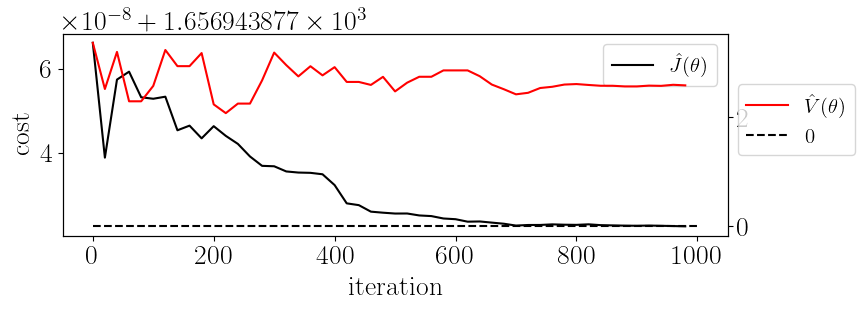

In [8]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":20,
    "font.family": "serif"
})

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(np.arange(0,epochs,20), (np.array(val_costs1)), c='k', label=r"$\hat{J}(\theta)$")
ax1 = ax.twinx()
ax1.plot(np.arange(0,epochs,20),(np.array(val_costs_constr1)/50), color = 'red', 
linestyle = "-", label = r"$\hat{V}(\theta)$")
ax1.hlines(y=0,xmin=0,xmax=epochs, color= "black", linestyle = "--", label = "0")
# plt.ylim([-0.03,0.015])
ax.set_xlabel('iteration')
ax.set_ylabel('cost')
fig.tight_layout()
plt.legend(fontsize = 15, bbox_to_anchor=(1, 0.8))
ax.legend(fontsize = 15)
plt.savefig("port_iters.pdf", bbox_inches='tight')
plt.show()
#0.9/20, init 0.001,5/15 batch, eps0.1, cvar 100,0.01, seed 10, clarabel, context, p=c5 h=c, 

In [64]:
x_base1

[[[tensor([[45.8085,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
           [48.2857,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
           [31.2498,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [70.4093,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
           [55.7251,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
           [69.5862,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000]],
          dtype=torch.float64),
   tensor([[ 0.6666,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000],
           [-0.1763,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000],
           [-1.2450,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.1127,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000],
           [ 1.6027,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000],
           [-0.6616,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000]],
          dtype=torch.float64),
   tensor([[-0.2817,  1.25

In [67]:
u_base1[1][0]

[tensor([[1020.8582,  166.6667],
         [1018.3810,  166.6667],
         [1035.4168,  166.6667],
         [1005.1645,  166.6667],
         [1045.2719,  166.6667],
         [1025.4840,  166.6667],
         [ 997.2873,  166.6667],
         [ 969.7358,  166.6667],
         [1004.8871,  166.6667],
         [1033.6301,  166.6667],
         [1011.8725,  166.6667],
         [1022.2703,  166.6667],
         [ 996.2574,  166.6667],
         [1010.9416,  166.6667],
         [ 997.0804,  166.6667]], dtype=torch.float64),
 tensor([[1137.4369,  212.5943],
         [1138.2797,  212.5943],
         [1139.3484,  212.5943],
         [1137.9795,  212.5943],
         [1138.0974,  212.5943],
         [1135.0120,  212.5943],
         [1136.9528,  212.5943],
         [1138.5693,  212.5943],
         [1138.8288,  212.5943],
         [1137.4231,  212.5943],
         [1138.0802,  212.5943],
         [1137.9923,  212.5943],
         [1137.9908,  212.5943],
         [1136.5008,  212.5943],
         [1138.7650,

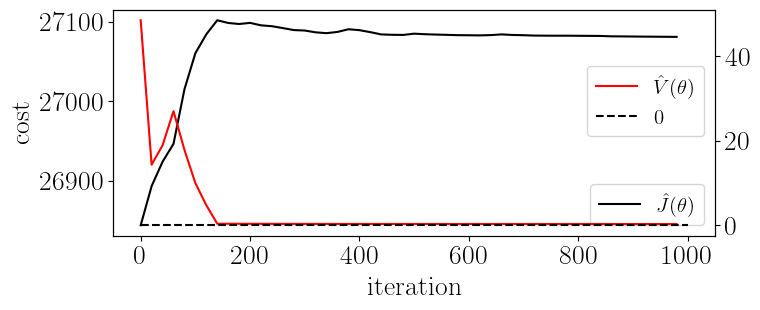

In [59]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":20,
    "font.family": "serif"
})

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(np.arange(0,1000,20), (np.array(val_costs3)), c='k', label=r"$\hat{J}(\theta)$")
ax1 = ax.twinx()
ax1.plot(np.arange(0,1000,20),(np.array(val_costs_constr3)/100), color = 'red', 
linestyle = "-", label = r"$\hat{V}(\theta)$")
ax1.hlines(y=0,xmin=0,xmax=1000, color= "black", linestyle = "--", label = "0")
# plt.ylim([-0.03,0.015])
ax.set_xlabel('iteration')
ax.set_ylabel('cost')
fig.tight_layout()
plt.legend(fontsize = 15, bbox_to_anchor=(1, 0.8))
ax.legend(fontsize = 15)
plt.savefig("port_iters.pdf", bbox_inches='tight')
plt.show()
#0.9/20, init 0.00001,5/15 batch, eps0.1, cvar 100,0.01, seed 10, clarabel, context, p=c5 h=c, 

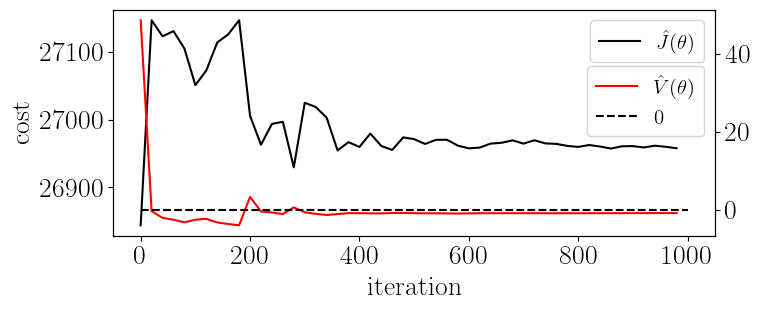

In [52]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":20,
    "font.family": "serif"
})

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(np.arange(0,1000,20), (np.array(val_costs2)), c='k', label=r"$\hat{J}(\theta)$")
ax1 = ax.twinx()
ax1.plot(np.arange(0,1000,20),(np.array(val_costs_constr2)/100), color = 'red', 
linestyle = "-", label = r"$\hat{V}(\theta)$")
ax1.hlines(y=0,xmin=0,xmax=1000, color= "black", linestyle = "--", label = "0")
# plt.ylim([-0.03,0.015])
ax.set_xlabel('iteration')
ax.set_ylabel('cost')
fig.tight_layout()
plt.legend(fontsize = 15, bbox_to_anchor=(1, 0.8))
ax.legend(fontsize = 15)
plt.savefig("port_iters.pdf", bbox_inches='tight')
plt.show()
#0.9/20, init 0.001,5/15 batch, eps0.1, cvar 100,0.01, seed 10, clarabel, noncontext, p=c5 h=c

In [54]:
x_base2

[[[tensor([[45.8085,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
           [48.2857,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
           [31.2498,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [70.4093,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
           [55.7251,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
           [69.5862,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000]],
          dtype=torch.float64),
   tensor([[ 0.6666,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000],
           [-0.1763,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000],
           [-1.2450,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.1127,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000],
           [ 1.6027,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000],
           [-0.6616,  1.1294,  1.1294,  ...,  0.0000,  0.0000,  0.0000]],
          dtype=torch.float64),
   tensor([[-0.2817,  1.25

In [57]:
u_base2[-1][0]

[tensor([[956.6925,   4.5915],
         [954.2153,   4.5915],
         [971.2511,   4.5915],
         [940.9988,   4.5915],
         [981.1062,   4.5915],
         [961.3183,   4.5915],
         [933.1216,   4.5915],
         [905.5701,   4.5915],
         [940.7214,   4.5915],
         [969.4644,   4.5915],
         [947.7067,   4.5915],
         [958.1046,   4.5915],
         [932.0917,   4.5915],
         [946.7759,   4.5915],
         [932.9147,   4.5915]], dtype=torch.float64),
 tensor([[1128.4012,    5.1459],
         [1129.2440,    5.1459],
         [1130.3127,    5.1459],
         [1128.9438,    5.1459],
         [1129.0617,    5.1459],
         [1125.9763,    5.1459],
         [1127.9171,    5.1459],
         [1129.5335,    5.1459],
         [1129.7931,    5.1459],
         [1128.3874,    5.1459],
         [1129.0444,    5.1459],
         [1128.9565,    5.1459],
         [1128.9550,    5.1459],
         [1127.4650,    5.1459],
         [1129.7293,    5.1459]], dtype=torch.floa

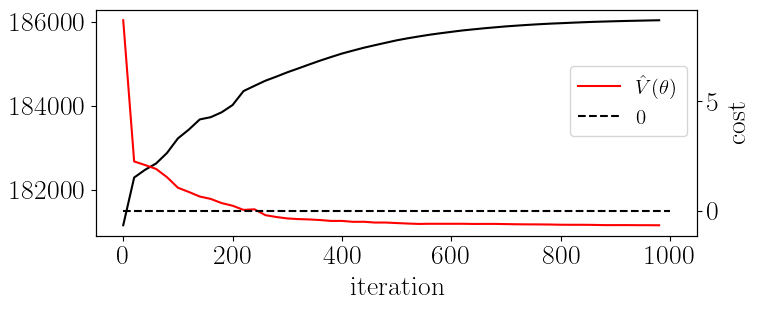

In [23]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":20,
    "font.family": "serif"
})

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(np.arange(0,1000,20), (np.array(val_costs1)), c='k', label=r"$\hat{J}(\theta)$")
ax1 = ax.twinx()
ax1.plot(np.arange(0,1000,20),(np.array(val_costs_constr1)/100), color = 'red', 
linestyle = "-", label = r"$\hat{V}(\theta)$")
ax1.hlines(y=0,xmin=0,xmax=1000, color= "black", linestyle = "--", label = "0")
# plt.ylim([-0.03,0.015])
ax.set_xlabel('iteration')
ax.set_ylabel('cost')
fig.tight_layout()
plt.legend(fontsize = 15, bbox_to_anchor=(1, 0.8))
plt.savefig("port_iters.pdf", bbox_inches='tight')
plt.show()
#0.9/20, init 0.001,5/15 batch, eps0.1, cvar 100,0.01, seed 10, clarabel, noncontext, h=c5, p=c

In [31]:
x_base1

[[[tensor([[45.8085,  1.0000,  5.0000,  ...,  0.0000,  0.0000,  0.0000],
           [48.2857,  1.0000,  5.0000,  ...,  0.0000,  0.0000,  0.0000],
           [31.2498,  1.0000,  5.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [70.4093,  1.0000,  5.0000,  ...,  0.0000,  0.0000,  0.0000],
           [55.7251,  1.0000,  5.0000,  ...,  0.0000,  0.0000,  0.0000],
           [69.5862,  1.0000,  5.0000,  ...,  0.0000,  0.0000,  0.0000]],
          dtype=torch.float64),
   tensor([[-224.8266,    1.1294,    5.6470,  ...,    0.0000,    0.0000,
               0.0000],
           [-224.4385,    1.1294,    5.6470,  ...,    0.0000,    0.0000,
               0.0000],
           [-234.0480,    1.1294,    5.6470,  ...,    0.0000,    0.0000,
               0.0000],
           ...,
           [-213.3178,    1.1294,    5.6470,  ...,    0.0000,    0.0000,
               0.0000],
           [-218.9849,    1.1294,    5.6470,  ...,    0.0000,    0.0000,
               0.0000],
           [

In [40]:
u_base1[0][0]

[tensor([[728.7650, 225.5265],
         [727.5187, 224.2956],
         [736.0138, 232.8364],
         [720.8078, 217.7901],
         [740.8465, 237.8588],
         [731.0824, 227.8350],
         [716.7589, 213.9617],
         [702.3136, 200.8555],
         [720.6658, 217.6546],
         [735.1312, 231.9322],
         [724.2268, 221.0790],
         [729.4738, 226.2298],
         [716.2268, 213.4639],
         [723.7540, 220.6210],
         [716.6521, 213.8617]], dtype=torch.float64),
 tensor([[673.4745, 768.9716],
         [673.6068, 768.3839],
         [670.3679, 782.8950],
         [675.9477, 758.0536],
         [669.1175, 788.5667],
         [673.5142, 768.7953],
         [677.6421, 750.6565],
         [681.7356, 733.0567],
         [675.7003, 759.1392],
         [671.3137, 778.6312],
         [674.7769, 763.2041],
         [673.0463, 770.8768],
         [677.4526, 751.4806],
         [675.4795, 760.1096],
         [677.0422, 753.2679]], dtype=torch.float64),
 tensor([[ 555.5477, 171

In [41]:
u_base1[-1][0]

[tensor([[656.3796, 302.8868],
         [655.0310, 301.7582],
         [664.2478, 309.5772],
         [647.7894, 295.7833],
         [669.5172, 314.1630],
         [658.8903, 305.0020],
         [643.4363, 292.2592],
         [627.9992, 280.1447],
         [647.6366, 295.6587],
         [663.2875, 308.7508],
         [651.4746, 298.8060],
         [657.1470, 303.5314],
         [642.8652, 291.8004],
         [650.9645, 298.3853],
         [643.3216, 292.1670]], dtype=torch.float64),
 tensor([[651.4409, 882.3660],
         [651.5159, 881.9585],
         [649.2054, 894.6059],
         [653.1737, 872.9991],
         [648.3497, 899.3387],
         [651.5222, 881.9244],
         [654.3900, 866.4855],
         [657.2421, 851.4078],
         [652.9811, 874.0351],
         [649.9161, 890.6954],
         [652.3457, 877.4617],
         [651.1266, 884.0763],
         [654.2345, 867.3153],
         [652.8753, 874.6047],
         [653.9289, 868.9490]], dtype=torch.float64),
 tensor([[ 549.7891, 185

In [277]:
xinit = np.random.rand()
hh = np.random.rand()
cc = np.random.rand()
pp = cc +  np.random.rand()
aa = np.random.rand()
bb = aa + np.random.rand()
print(cc,hh,pp,aa,bb)

0.3752098217129797 0.688338564596957 0.5867388484912102 0.8209913422120398 0.9355657802976483


In [278]:
xx = cp.Variable()
yy = cp.Variable()
val = max((hh*aa + pp*bb -hh*xinit - pp*xinit)/(hh+pp),0)
obj = cp.Minimize(cc*xx + yy)
cons = [yy>= hh*xx + hh*xinit - hh*aa, yy >= -pp*xx - pp*xinit + pp*bb, xx >=0]
prob = cp.Problem(obj,cons)
prob.solve()
xx.value, (hh*aa + pp*bb -hh*xinit - pp*xinit)/(hh+pp), yy.value, prob.objective.value

(array(0.66821315), 0.668213145690562, array(0.03629093), 0.28701106790895964)

In [280]:
xinit = np.random.rand()
xx = cp.Variable()
yy = cp.Variable()
val = max((hh*aa + pp*bb -hh*xinit - pp*xinit)/(hh+pp),0)
obj = cp.Minimize(cc*xx + yy)
cons = [yy>= hh*xx + hh*xinit - hh*aa, yy >= -pp*xx - pp*xinit + pp*bb, xx >=0]
prob = cp.Problem(obj,cons)
prob.solve()
xx.value, (hh*aa + pp*bb -hh*xinit - pp*xinit)/(hh+pp), yy.value, prob.objective.value

(array(0.39065333), 0.3906533280416337, array(0.03629093), 0.18286789821421814)